In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.python.lib.io import file_io

import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D

import skimage
from skimage.transform import rescale, resize
from skimage import io

from sklearn.metrics import confusion_matrix
from seaborn import heatmap

import pydot

import dlib
import cv2
import random
import time

import sklearn

Using TensorFlow backend.


In [3]:
BS=32

def facial_landmarks(image, predictor):
    #image = cv2.imread(filepath)
    face_rects = [dlib.rectangle(left=1, top=1, right=len(image)-1, bottom=len(image)-1)]
    face_landmarks = np.matrix([[p.x, p.y] for p in predictor(image, face_rects[0]).parts()])
    return face_landmarks

def load_filenames(directory):
    emotions_dict = {"anger":0, "disgust":1, "fear":2, "happiness":3, "neutrality":4, "sadness":5, "surprise":6}
    samples = []
    for emotion in emotions_dict:
        path = directory + "/" + emotion
        for file in os.listdir(path):
            if file.endswith(".png"):
                filepath = path + "/" + file
                emotion_label = emotions_dict[emotion]
                samples.append([filepath, emotion_label])
    return samples

def rotate_image(image,deg):
    rows, cols,c = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), deg, 1)
    image = cv2.warpAffine(image, M, (cols, rows))
    return image

predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def load_files(batch_samples, aug=False, modified=True, detect_face=False, resize=197):
    # Initialise X_train and y_train arrays for this batch
    X1 = []
    X2 = []
    Y = []

    # For each example
    for batch_sample in batch_samples:
        # Load image (X) and label (y)
        img_path = batch_sample[0]
        label = batch_sample[1]
        if not modified:
            # emotions_dict_unmod = {"anger":0, "disgust":1, "fear":2, "happiness":3, "sadness":4, "surprise":5, "neutrality":6}
            # 4->6, 5->4, 6->5
            if label==4:
                label=6
            elif label==5:
                label=4
            elif label==6:
                label=5
        img =  cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        if detect_face:
            faces = faceCascade.detectMultiScale(
                gray,
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(30, 30),
            )
            img = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)
            for (x, y, w, h) in faces:
                #cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
                img = img[y:y+h, x:x+w]
        else:
            img = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)
            
        img = cv2.resize(img,(resize,resize))
        
        if aug: #augumentations
            img = rotate_image(img, random.uniform(-5, 5))
            
        if modified:
            features = facial_landmarks(img, predictor)
            
        img = img/255

        onehot = [0 for i in range(7)]
        onehot[label] += 1

        # apply any kind of preprocessing                
        # Add example to arrays
        X1.append(img)
        if modified:
            X2.append(features)
        Y.append(onehot)
        
    X1 = np.array(X1)
    if modified:
        X2 = np.array(X2)
    Y = np.array(Y)
    
    if modified:
        return [X1, X2], Y
    
    return X1, Y
    

def generator(samples, aug=False, detect_face=False, batch_size=BS, modified=True, shuffle_data=True, resize=197):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        if shuffle_data:
            random.shuffle(samples)
            
        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            X, Y = load_files(batch_samples, aug=aug, modified=modified, detect_face=detect_face, resize=resize)

            # The generator-y part: yield the next training batch            
            yield X, Y

In [4]:
def preds2onehot(preds):
    onehots = []
    for pred in preds:
        row = [0 for i in range(7)]
        row[np.argmax(pred)] += 1
        onehots.append(row)
    onehots = np.array(onehots)
    return onehots

def onehot2label(onehots):
    labels = []
    for onehot in onehots:
        labels.append(np.argmax(onehot))
    labels = np.array(labels)
    return labels

def compute_metrics(model_paths, test_files, compare_face_detection=True, gpu=False):
    string1 = 'single prediction time (' + str(len(test_files)) + ' files)'
    string2 = 'batch prediction time (' + str(len(test_files)) + ' files)'
    metrics = [['model', 'face detection', 'model load time', 'single prediction time (one file)', string1, string2, 'accuracy', 'precision', 'f1 score', 'ROC AUC', 'confusion matrix']]
    
    onceortwice = 1
    if compare_face_detection:
        onceortwice += 1
    
    device = '/cpu:0'
    if gpu:
        device = '/gpu:0'
       
    for model_path in model_paths:
        with tf.device(device):
            for i in range(onceortwice):
                if i==0:
                    face=False
                if i==1:
                    face=True

                try:
                    print("Evaluating ", model_path, "...", " (FACE DETECTION)" if face else ' (NO FACE DETECTION)', sep="")

                    row = []
                    row.append(model_path)
                    row.append(face)

                    if i==0:
                        print("Loading model...")
                        start_time = time.time()
                        model = load_model(model_path)
                        load_time = time.time() - start_time
                        row.append(load_time)
                    if i==1:
                        print("Model already loaded.")
                        row.append("-")

                    if model_path.startswith('new'):
                        mod = True
                    if model_path.startswith('cs'):
                        mod = False

                    Y = []
                    Y_preds = []
                    pred_times = []
                    print("Making predictions on single files...")
                    for file in test_files:
                        start_time = time.time()
                        X, Y_tmp = load_files([file], modified=mod, detect_face=face)
                        Y_pred = model.predict(X)
                        pred_time = time.time() - start_time
        #                 Y.append(Y_tmp[0].tolist())
        #                 Y_preds.append(Y_pred[0].tolist())
                        pred_times.append(pred_time)

                    row.append(np.mean(pred_times))
                    row.append(sum(pred_times))

                    print("Making predictions on all files...")
                    start_time = time.time()
                    X, Y = load_files(test_files, modified=mod, detect_face=face)
                    Y_preds = model.predict(X)
                    pred_time = time.time() - start_time
                    row.append(pred_time)

                    print("Calculating metrics...")
                    Y_preds_onehot = preds2onehot(Y_preds)
                    Y_preds_label = onehot2label(Y_preds_onehot)
                    Y_label = onehot2label(Y)

                    acc = sklearn.metrics.accuracy_score(Y, Y_preds_onehot)
                    prec = sklearn.metrics.precision_score(Y, Y_preds_onehot, average='macro')
                    f1 = sklearn.metrics.f1_score(Y, Y_preds_onehot, average='macro')
                    roc_auc = sklearn.metrics.roc_auc_score(Y, Y_preds_onehot)
                    conf = sklearn.metrics.confusion_matrix(Y_label, Y_preds_label)

                    row.append(acc)
                    row.append(prec)
                    row.append(f1)
                    row.append(roc_auc)
                    row.append(conf)
                    metrics.append(row)
                except Exception as e:
                    print(e)
        del model
        K.clear_session()
                
    return metrics

In [5]:
root_pic_dir = "C:/Users/hp/Documents/data/"
pic_dirs = ['train', 'dev', 'test']

files_train = load_filenames(root_pic_dir + 'train')
files_dev = load_filenames(root_pic_dir + 'dev')
files_test = load_filenames(root_pic_dir + 'test')

In [6]:
model_paths = []
model_dirs = ['newmodels', 'cs230-models']

for model_dir in model_dirs:
    for file in os.listdir(model_dir):
        if file.endswith("h5"):
            model_paths.append(model_dir+'/'+file)

In [7]:
model_paths

['newmodels/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5',
 'newmodels/VGG19-MODYFIKACJA-EPOCHS_20test_acc_0.592.h5',
 'newmodels/VGG19-MODYFIKACJA-EPOCHS_50test_acc_0.573.h5',
 'cs230-models/ResNet-BEST-73.2.h5',
 'cs230-models/RESNET50-WCW-AUX-BEST-72.4.h5',
 'cs230-models/SENET50-AUX-BEST-72.5.h5',
 'cs230-models/SENET50-WCW-AUX-BEST-71.6.h5',
 'cs230-models/VGG16-AUX-BEST-70.2.h5']

In [8]:
metrics_cpu = compute_metrics(model_paths, files_test, compare_face_detection=True, gpu=False)

Evaluating newmodels/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5... (NO FACE DETECTION)
Loading model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Making predictions on single files...
Making predictions on all files...
Calculating metrics...
Evaluating newmodels/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5... (FACE DETECTION)
Model already loaded.
Making predictions on single files...
Making predictions on all files...
Calculating metrics...
Evaluating newmodels/VGG19-MODYFIKACJA-EPOCHS_20test_acc_0.592.h5... (NO FACE DETECTION)
Loading model...
Making predictions on single files...
Making predictions on all files...
Calculating metrics...
Evaluating newmodels/VGG19-MODYFIKACJA-EPOCHS_20test_acc_0.592.h5... (FACE DETECTION)
Model already loaded.
Making predictions on single files...
Making predictions on all files...
Calculating metrics...
Evaluating newmodels/VGG19-MODYFIKACJA-EPOCHS_50test_acc_0.573.h5... (NO FACE DETECTION)
Loading m

In [9]:
metrics_gpu = compute_metrics(model_paths, files_test, compare_face_detection=True, gpu=True)

Evaluating newmodels/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5... (NO FACE DETECTION)
Loading model...
Making predictions on single files...
Making predictions on all files...
Calculating metrics...
Evaluating newmodels/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5... (FACE DETECTION)
Model already loaded.
Making predictions on single files...
Making predictions on all files...
Calculating metrics...
Evaluating newmodels/VGG19-MODYFIKACJA-EPOCHS_20test_acc_0.592.h5... (NO FACE DETECTION)
Loading model...
Making predictions on single files...
Making predictions on all files...
Calculating metrics...
Evaluating newmodels/VGG19-MODYFIKACJA-EPOCHS_20test_acc_0.592.h5... (FACE DETECTION)
Model already loaded.
Making predictions on single files...
Making predictions on all files...
Calculating metrics...
Evaluating newmodels/VGG19-MODYFIKACJA-EPOCHS_50test_acc_0.573.h5... (NO FACE DETECTION)
Loading model...
Making predictions on single files...
Making predictions on all files...
Cal

In [17]:
# np.save("metrics_gpu", metrics_gpu)
# np.save("metrics_cpu", metrics_cpu)

In [45]:
np.load("metrics_cpu.npy", allow_pickle=True)

array([['model', 'face detection', 'model load time',
        'single prediction time (one file)',
        'single prediction time (490 files)',
        'batch prediction time (490 files)', 'accuracy', 'precision',
        'f1 score', 'ROC AUC', 'confusion matrix'],
       ['newmodels/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5',
        False, 12.94091534614563, 0.13330778297112914, 65.32081365585327,
        68.8231406211853, 0.6857142857142857, 0.7623431133135191,
        0.6639968740242681, 0.8166666666666667,
        array([[60,  0,  0,  0,  5,  5,  0],
       [44, 13,  1,  0,  3,  9,  0],
       [11,  0, 28,  1,  4, 19,  7],
       [ 0,  0,  0, 69,  1,  0,  0],
       [ 6,  0,  1,  0, 53, 10,  0],
       [ 4,  0,  1,  0,  9, 56,  0],
       [ 1,  0,  5,  1,  6,  0, 57]], dtype=int64)],
       ['newmodels/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5',
        True, '-', 0.13974756610636807, 68.47630739212036,
        74.22658276557922, 0.7489795918367347, 0.7782918580537628

In [46]:
np.load("metrics_gpu.npy", allow_pickle=True)

array([['model', 'face detection', 'model load time',
        'single prediction time (one file)',
        'single prediction time (490 files)',
        'batch prediction time (490 files)', 'accuracy', 'precision',
        'f1 score', 'ROC AUC', 'confusion matrix'],
       ['newmodels/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5',
        False, 13.573517560958862, 0.05957688214827557,
        29.19267225265503, 15.013283491134644, 0.6857142857142857,
        0.7623431133135191, 0.6639968740242681, 0.8166666666666667,
        array([[60,  0,  0,  0,  5,  5,  0],
       [44, 13,  1,  0,  3,  9,  0],
       [11,  0, 28,  1,  4, 19,  7],
       [ 0,  0,  0, 69,  1,  0,  0],
       [ 6,  0,  1,  0, 53, 10,  0],
       [ 4,  0,  1,  0,  9, 56,  0],
       [ 1,  0,  5,  1,  6,  0, 57]], dtype=int64)],
       ['newmodels/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5',
        True, '-', 0.06632205661462277, 32.49780774116516,
        17.325016498565674, 0.7489795918367347, 0.778291858053

In [37]:
# pd.DataFrame(metrics_cpu).to_csv('metrics_cpu.csv', header=False, index=False)
# pd.DataFrame(metrics_gpu).to_csv('metrics_gpu.csv', header=False, index=False)

In [55]:
df = pd.read_csv('metrics_cpu.csv', index_col=0) #.reset_index(drop=True)
df.iloc[:,:-1].to_csv('metrics_cpu_noconfmat.csv', header=True, index=True)

In [56]:
df = pd.read_csv('metrics_gpu.csv', index_col=0) 
df.iloc[:,:-1].to_csv('metrics_gpu_noconfmat.csv', header=True, index=True)

In [75]:
df.iloc[:,:-1]

,face detection,model load time,single prediction time (one file),single prediction time (490 files),batch prediction time (490 files),accuracy,precision,f1 score,ROC AUC
model,,,,,,,,,
newmodels/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5,False,13.573517560958862,0.059577,29.192672,15.013283,0.685714,0.762343,0.663997,0.816667
newmodels/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5,True,-,0.066322,32.497808,17.325016,0.748980,0.778292,0.740690,0.853571
newmodels/VGG19-MODYFIKACJA-EPOCHS_20test_acc_0.592.h5,False,4.148468017578125,0.056212,27.543988,13.441723,0.595918,0.682758,0.551129,0.764286
newmodels/VGG19-MODYFIKACJA-EPOCHS_20test_acc_0.592.h5,True,-,0.065939,32.310113,18.055923,0.742857,0.757594,0.734089,0.850000
newmodels/VGG19-MODYFIKACJA-EPOCHS_50test_acc_0.573.h5,False,3.5053253173828125,0.051458,25.214310,12.558436,0.581633,0.660528,0.540734,0.755952
newmodels/VGG19-MODYFIKACJA-EPOCHS_50test_acc_0.573.h5,True,-,0.064731,31.718339,18.371264,0.720408,0.749545,0.719008,0.836905
cs230-models/ResNet-BEST-73.2.h5,False,12.378300428390503,0.049693,24.349808,9.854091,0.548980,0.595904,0.524863,0.736905
cs230-models/ResNet-BEST-73.2.h5,True,-,0.061575,30.171618,14.835207,0.606122,0.650622,0.599350,0.770238
cs230-models/RESNET50-WCW-AUX-BEST-72.4.h5,False,12.554004907608032,0.050309,24.651644,9.881302,0.659184,0.686323,0.653266,0.801190


In [73]:
metrics_gpu

[['model',
  'face detection',
  'model load time',
  'single prediction time (one file)',
  'single prediction time (490 files)',
  'batch prediction time (490 files)',
  'accuracy',
  'precision',
  'f1 score',
  'ROC AUC',
  'confusion matrix'],
 ['newmodels/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5',
  False,
  13.573517560958862,
  0.05957688214827557,
  29.19267225265503,
  15.013283491134644,
  0.6857142857142857,
  0.7623431133135191,
  0.6639968740242681,
  0.8166666666666667,
  array([[60,  0,  0,  0,  5,  5,  0],
         [44, 13,  1,  0,  3,  9,  0],
         [11,  0, 28,  1,  4, 19,  7],
         [ 0,  0,  0, 69,  1,  0,  0],
         [ 6,  0,  1,  0, 53, 10,  0],
         [ 4,  0,  1,  0,  9, 56,  0],
         [ 1,  0,  5,  1,  6,  0, 57]], dtype=int64)],
 ['newmodels/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5',
  True,
  '-',
  0.06632205661462277,
  32.49780774116516,
  17.325016498565674,
  0.7489795918367347,
  0.7782918580537628,
  0.7406896789726114,
  0.

In [78]:
metrics_cpu

[['model',
  'face detection',
  'model load time',
  'single prediction time (one file)',
  'single prediction time (490 files)',
  'batch prediction time (490 files)',
  'accuracy',
  'precision',
  'f1 score',
  'ROC AUC',
  'confusion matrix'],
 ['newmodels/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5',
  False,
  12.94091534614563,
  0.13330778297112914,
  65.32081365585327,
  68.8231406211853,
  0.6857142857142857,
  0.7623431133135191,
  0.6639968740242681,
  0.8166666666666667,
  array([[60,  0,  0,  0,  5,  5,  0],
         [44, 13,  1,  0,  3,  9,  0],
         [11,  0, 28,  1,  4, 19,  7],
         [ 0,  0,  0, 69,  1,  0,  0],
         [ 6,  0,  1,  0, 53, 10,  0],
         [ 4,  0,  1,  0,  9, 56,  0],
         [ 1,  0,  5,  1,  6,  0, 57]], dtype=int64)],
 ['newmodels/RESNET50-MODYFIKACJA-EPOCHS_30test_acc_0.681.h5',
  True,
  '-',
  0.13974756610636807,
  68.47630739212036,
  74.22658276557922,
  0.7489795918367347,
  0.7782918580537628,
  0.7406896789726114,
  0.8535

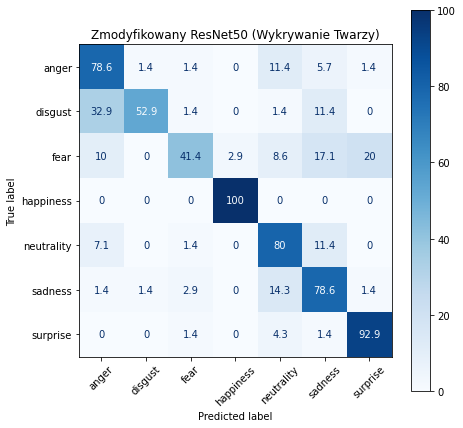

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = metrics_cpu[2][-1]
classes=["anger", "disgust", "fear", "happiness", "neutrality", "sadness", "surprise"]
plt.rcParams["figure.figsize"] = (7,7)

np.round(cm, 1)

disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm*100/70, 1),
                              display_labels=classes)

disp.plot(cmap=plt.cm.Blues, values_format='.3g')
disp.im_.set_clim(0, 100)
plt.xticks(rotation=45)
plt.title("Zmodyfikowany ResNet50 (Wykrywanie Twarzy)")
plt.show()